In [1]:
import polars as pl
import glob
import pandas as pd
from scipy.stats import skew 
from scipy.stats import kurtosis 
from statsmodels.tsa.stattools import adfuller
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
%matplotlib inline

# Step 0: Read in Data (2022)

In [2]:
path = 'D:\\qr_takehome\\'
#df = pl.read_parquet(path).to_pandas()

In [684]:
data = []
for file_name in glob.glob(path+'*.parquet'):
    print(file_name)
    x = pl.read_parquet(file_name, low_memory=False).to_pandas()
    data.append(x)

D:\qr_takehome\QR_TAKEHOME_20230103.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20230104.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20230105.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20230106.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20230109.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20230110.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20230111.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20230112.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20230113.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20230117.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20230118.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20230119.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20230120.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20230123.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20230125.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20230126.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20230127.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20230130.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20230131.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20230201.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20230202.csv.

In [685]:
data_frame = pd.concat(data, axis=0, ignore_index=True)

In [5]:
del data

# Step 2: Linear Regression Model

### 1. Data Preparation

In [686]:
data_all = data_frame.fillna(method='ffill')

In [687]:
del data_frame

In [688]:
step_size = 30
data_minute = data_all.iloc[::step_size, :]

In [689]:
data_minute

,time,sym,exch,Q1,Q2,X1,X10,X100,X101,X102,...,X92,X93,X94,X95,X96,X97,X98,X99,Y1,Y2
0,35101000,SPX,cme,1.00,1.00,-0.734011,-1.724837,1.664375,1.555895,0.081482,...,0.140051,0.168822,2.871825,1.018687,2.417811,-0.868493,0.358125,0.624525,-48.198967,-64.970772
30,35131000,SPX,cme,1.00,1.00,0.115502,-0.477742,0.833457,0.541575,1.279984,...,1.328011,1.064462,2.582010,0.020976,1.291900,0.163235,1.059291,0.534776,-27.027897,-41.124519
60,35161000,SPX,cme,1.00,1.00,0.898322,-0.562420,0.347998,0.465096,1.102466,...,1.136634,1.009915,2.935545,-0.971823,0.881355,-0.172405,0.938560,1.044392,-18.032522,-32.387936
90,35191000,SPX,cme,1.00,1.00,-0.464032,-1.072222,0.445928,0.471877,0.243100,...,0.270023,0.132500,1.634261,-0.793763,0.957247,-1.141723,0.008985,-0.169737,-18.680151,-35.085350
120,35221000,SPX,cme,1.00,1.00,0.707110,-0.526388,0.022841,-0.287234,0.537766,...,0.515095,0.499757,2.162903,-1.014118,0.323993,-0.735180,0.490418,0.506151,-23.819487,-46.274975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304850,57451000,SPX,cme,1.00,0.12,1.753197,-0.191971,0.460343,-0.302983,0.034320,...,-0.100822,-0.081113,0.444406,0.122235,-1.263797,1.507512,-0.610363,0.779679,0.604211,-1.409456
1304880,57481000,SPX,cme,1.00,0.12,1.138442,0.438502,0.460343,-0.169966,-0.789734,...,-0.767577,0.412396,-0.033100,0.122235,-1.117523,0.483430,-0.087505,0.211552,-0.604138,-1.879187
1304910,57511000,SPX,cme,0.21,0.12,1.089866,0.233647,0.460343,0.088169,0.246945,...,0.310646,0.265673,0.321799,0.122235,-0.708414,1.315984,-0.005467,0.526320,-4.227436,-4.414969
1304940,57541000,SPX,cme,1.00,0.12,1.013905,0.870364,0.460343,-0.387764,0.732585,...,0.652516,0.343849,-0.105299,0.122235,-1.054992,2.079151,0.341398,0.083418,-7.244845,-6.198638


In [ ]:
data_minute['Y2'].plot()

In [10]:
data_1 = data_minute[data_minute['Q2'] > 0.9999]
data_1 = data_1[data_1['Y2'] < 90]
data_1 = data_1[data_1['Y2'] > -75]

In [11]:
data_1 = data_1.reset_index()

In [14]:
data_1

,index,time,sym,exch,Q1,Q2,X1,X10,X100,X101,...,X92,X93,X94,X95,X96,X97,X98,X99,Y1,Y2
0,0,35101000,SPX,cme,1.0,1.0,-1.985130,-0.440099,0.044736,-0.010772,...,-0.496673,-0.419372,-2.094251,-0.544180,0.947544,-2.114019,-0.783769,-0.229752,-49.671906,-61.707756
1,30,35131000,SPX,cme,1.0,1.0,-1.452239,0.060381,-0.196124,-0.044381,...,0.275661,0.042741,-2.079329,-1.313715,0.406450,-1.470698,-0.495086,-0.132580,-60.693264,-73.067146
2,60,35161000,SPX,cme,1.0,1.0,-2.063190,-0.161842,-0.186621,-0.245961,...,-0.575394,-0.657108,-2.892859,-1.369803,0.173069,-2.160242,-1.097313,-0.772604,-53.897072,-67.343399
3,90,35191000,SPX,cme,1.0,1.0,-0.654069,0.286368,-0.031855,-0.364002,...,0.004832,0.122860,-1.842357,-1.433200,-0.210508,-1.669639,-0.435580,0.315721,-39.795784,-56.519554
4,120,35221000,SPX,cme,1.0,1.0,-0.449629,-0.323717,-0.632133,-1.026018,...,-0.491058,-0.810593,-2.083188,-1.794230,-0.686079,-2.117335,-1.320655,0.027379,-31.422661,-55.768456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171814,5399130,56731000,SPX,cme,1.0,1.0,0.100052,0.696557,-0.301966,-0.307203,...,-0.235025,-0.094906,-0.030170,0.022761,-0.342202,0.518739,0.409839,-0.326102,20.781244,24.963524
171815,5399160,56761000,SPX,cme,1.0,1.0,-0.078413,0.715683,0.009647,0.001111,...,-0.006348,-0.021218,0.012501,0.301764,-0.115235,0.688409,0.532300,-0.278025,16.877089,21.193441
171816,5399190,56791000,SPX,cme,1.0,1.0,-0.374154,0.200332,-0.173260,-0.218176,...,-1.104840,-0.710900,-0.418258,0.221457,-0.247869,-0.372772,-0.188443,-0.670028,15.574808,17.995853
171817,5399220,56821000,SPX,cme,1.0,1.0,-0.401871,0.732595,0.216600,0.390600,...,0.700685,0.324355,0.207296,0.638212,0.406129,1.345739,0.822691,0.026686,16.219547,20.042362


In [275]:
len(data_1)

171819

In [12]:
tscv = TimeSeriesSplit(gap=600, max_train_size=103356, n_splits=4, test_size=17226)

# Step 3: LightGBM Model

In [20]:
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial import distance

In [546]:
full_corr = data_1[top_15].corr()

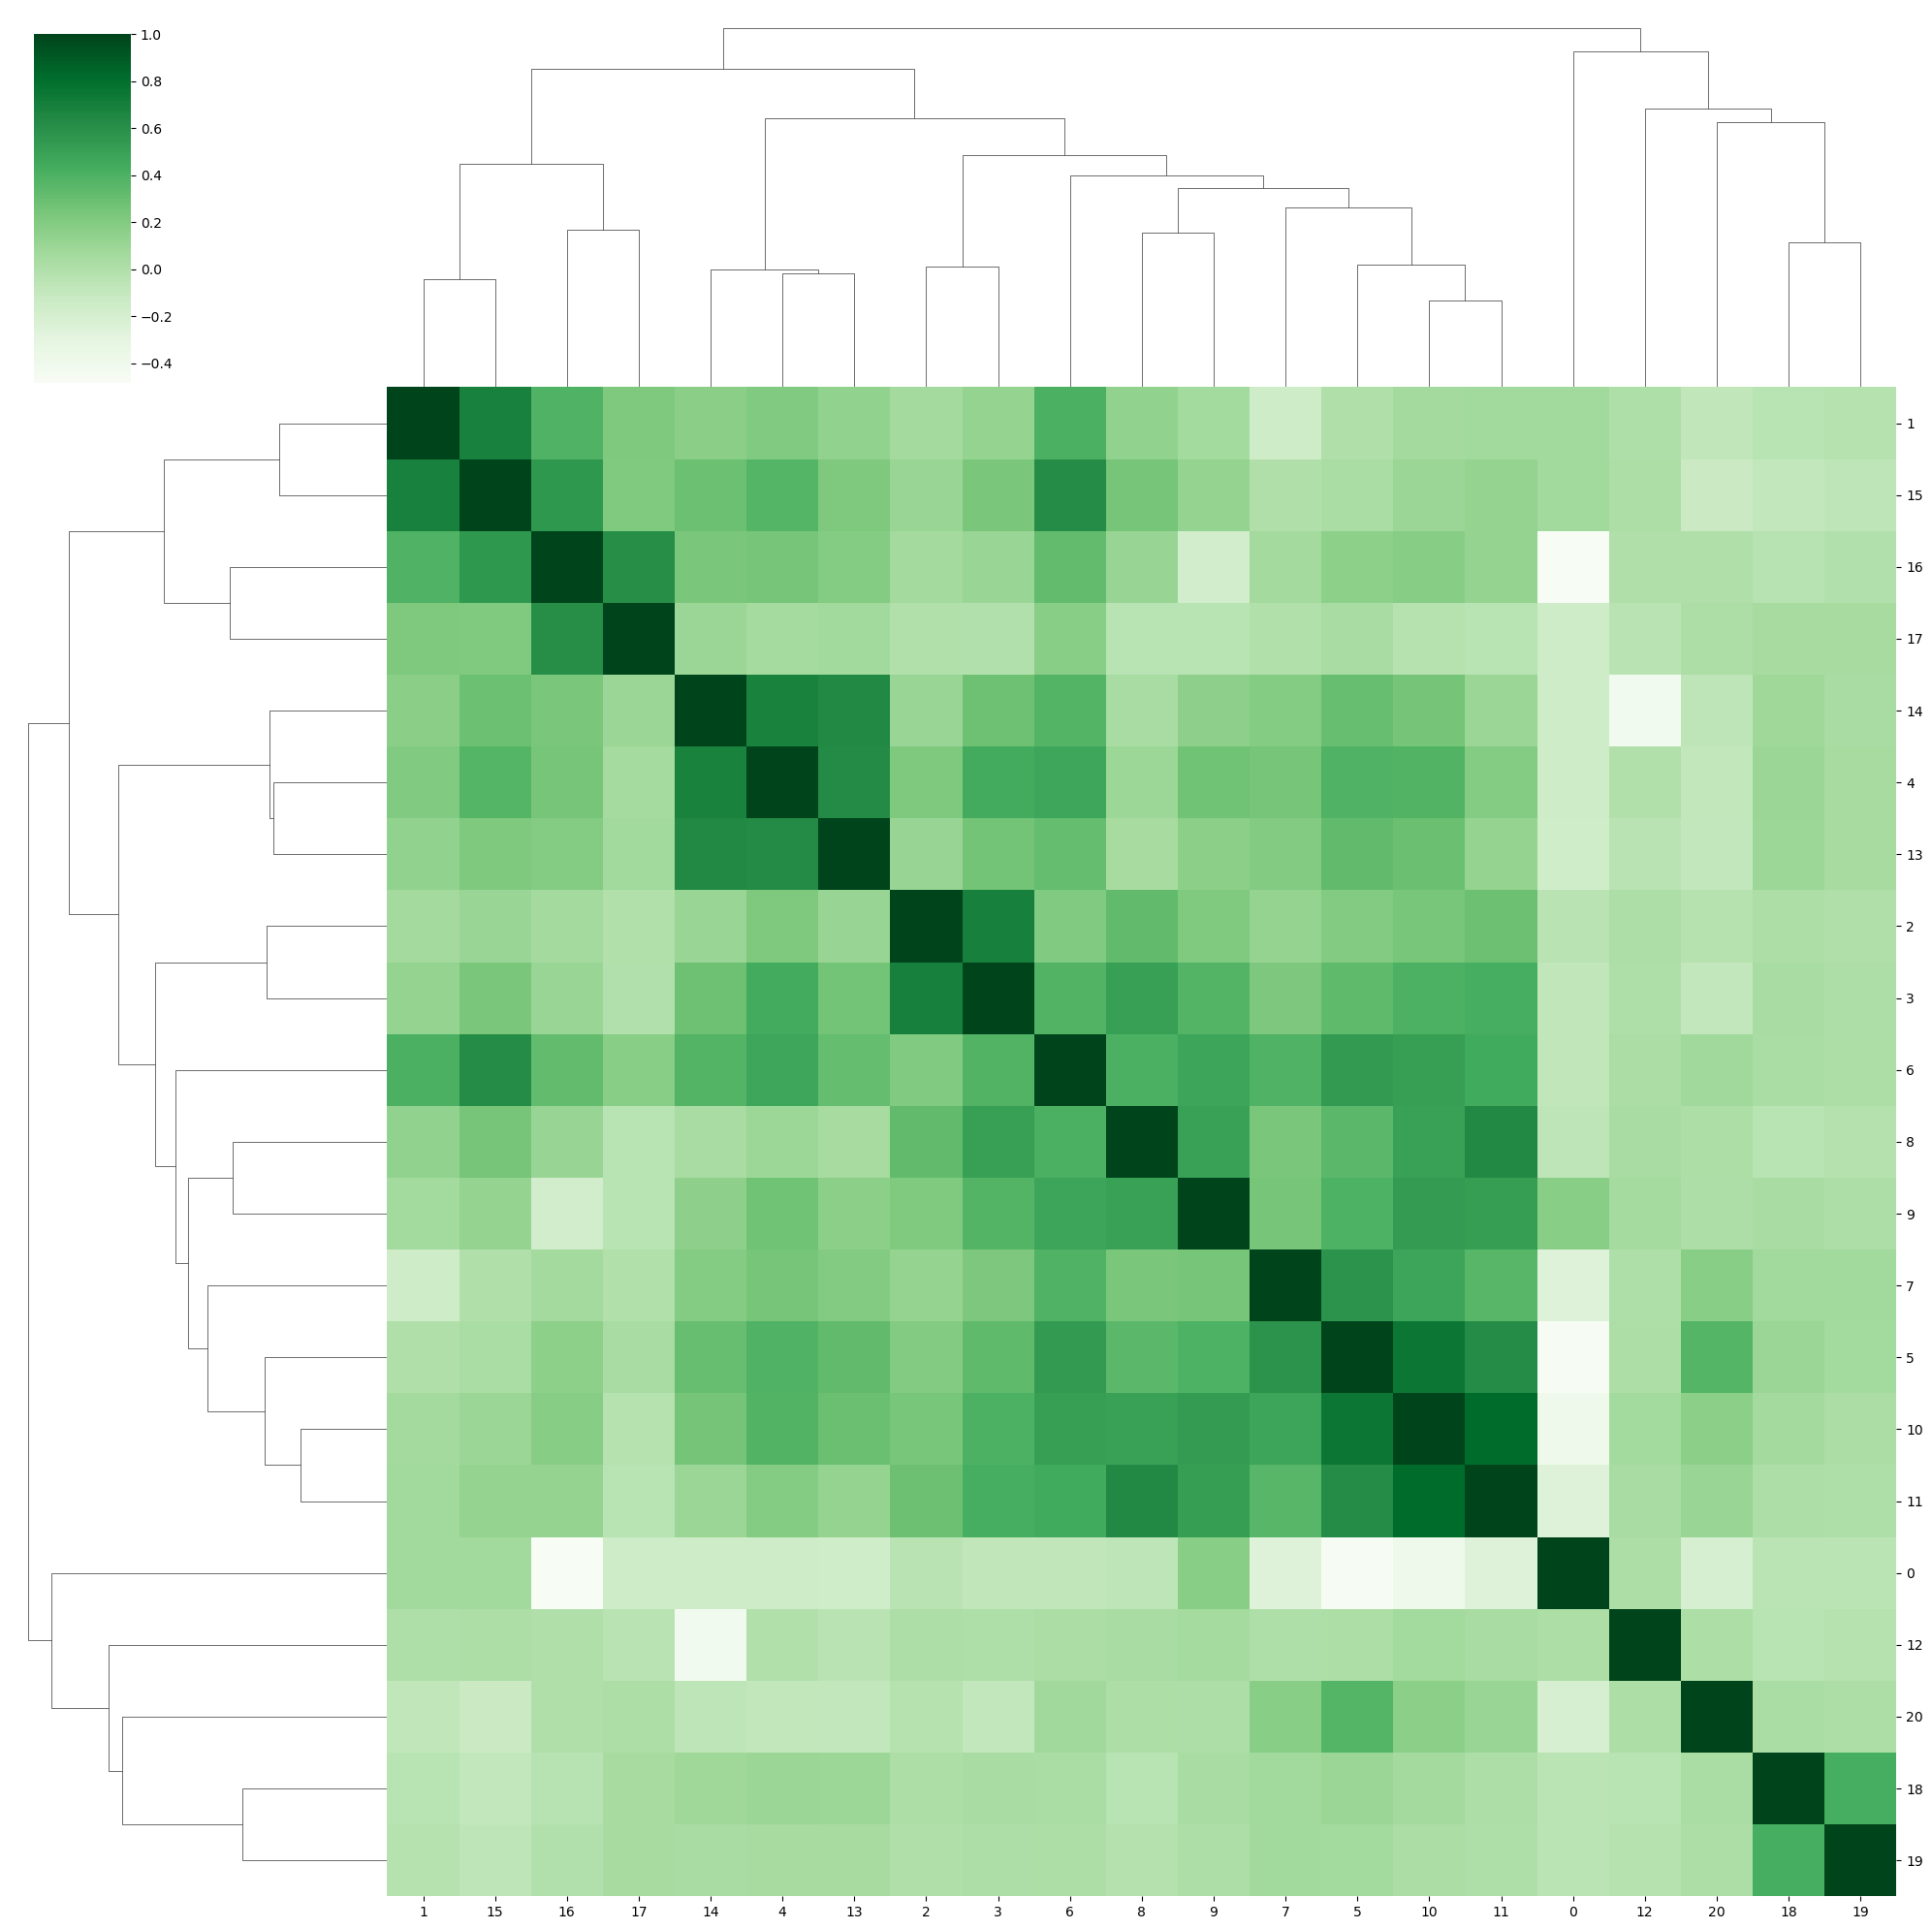

In [547]:
corr_array = np.asarray(full_corr)

linkage = hierarchy.linkage(distance.pdist(corr_array),method='average')

g = sns.clustermap(corr_array,row_linkage=linkage,col_linkage=linkage,row_cluster=True,col_cluster=True,figsize=(20,20),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

label_order = full_corr.iloc[:,g.dendrogram_row.reordered_ind].columns

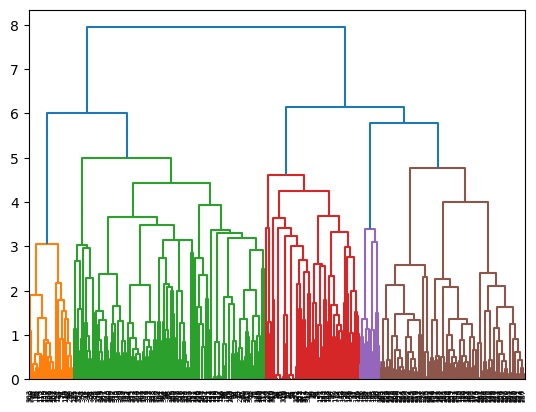

<Figure size 2500x1000 with 0 Axes>

In [27]:
dn = dendrogram(linkage)
fig = plt.figure(figsize=(25, 10))
plt.show()

In [42]:
from scipy.cluster.hierarchy import fcluster

In [90]:
cluster = fcluster(linkage, t=3.5, criterion='distance')
cluster

array([ 7,  2,  4,  4,  3,  3,  4,  4,  4,  3,  3,  4,  2,  4,  4,  3,  3,
       11, 11, 10, 10, 11, 11,  2, 11, 11, 11, 11, 10, 10, 11, 13, 10, 10,
        2, 12, 12, 12, 12, 12, 12, 12, 12, 11, 11,  2, 11, 11,  9,  9,  9,
        9,  9,  9,  9,  9,  2,  9,  9,  9,  9,  9,  9,  9,  9,  6,  6,  2,
        6,  6,  6,  6,  6,  6,  1,  1,  1,  1,  2,  6,  6,  6,  6,  1,  1,
        1,  1,  1,  1,  7,  1,  1,  6,  6,  6,  6,  4,  4,  4,  4,  7,  4,
        4,  4,  4,  1,  1,  1,  1,  6,  6,  2,  5,  6,  6,  1,  1,  1,  1,
        1,  1,  1,  1,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  5,  6,
        6,  1,  1,  1,  1, 11,  4, 10, 10,  5, 11, 11, 11, 11, 11,  4, 10,
       10, 11,  4,  5, 10, 10, 12, 12, 12, 12, 12, 12, 12, 12,  5, 11, 11,
       11, 11, 14, 14, 14, 14, 14, 14,  6, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14,  6, 14, 14,  4,  4,  3,  3, 13, 13, 15, 15,  6, 13, 13, 15,
       15, 13, 13, 15, 15, 13, 13,  6, 15, 15, 13, 13, 15, 15, 13, 13, 15,
       15,  7,  5, 13, 13

In [91]:
clusters = pd.DataFrame([data_1.columns[6:381],cluster]).T

In [92]:
clusters.columns = ['Feature', 'Cluster']
clusters

,Feature,Cluster
0,X1,7
1,X10,2
2,X100,4
3,X101,4
4,X102,3
...,...,...
370,X95,4
371,X96,4
372,X97,3
373,X98,3


In [94]:
clusters.groupby('Cluster').count()

,Feature
Cluster,
1,34
2,16
3,24
4,51
5,12
6,42
7,5
8,2
9,28


In [66]:
import lightgbm as lgb
from sklearn.metrics import r2_score

In [858]:
parameters = {
    'objective': ['regression'],
    'metric': ['rmse'],
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.3,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0,
    'early_stopping_rounds':30,
    'max_depth': 20,
    'num_leaves': 40
}

In [101]:
R2_shuffle = []
for i in range(1,376):
    data_shuffle = data_1.copy()
    data_shuffle['X'+str(i)] = np.random.permutation(data_shuffle['X'+str(i)].values)
    R2s = []

    for folder, (train_index, test_index) in enumerate(tscv.split(data_shuffle)):
        X_train = np.array(data_shuffle[data_shuffle.columns[6:381]].iloc[train_index])
        y_train = np.array(data_shuffle['Y2'][train_index])
        train_data = lgb.Dataset(X_train, label=y_train)
        X_test = np.array(data_shuffle[data_shuffle.columns[6:381]].iloc[test_index])
        y_test = np.array(data_shuffle['Y2'][test_index])
        test_data = lgb.Dataset(X_test, label=y_test)

        model = lgb.train(parameters, train_data, valid_sets=[test_data],num_boost_round=1000)
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        R2 = r2_score(y_test, y_pred)
        R2s.append(R2)
    R2_shuffle.append(np.mean(R2s))
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [103]:
R2_shuffle = pd.DataFrame(R2_shuffle)

In [113]:
top15 = R2_shuffle[R2_shuffle[R2_shuffle.columns[0]]<0][R2_shuffle.columns[0]].iloc[:15]

In [116]:
top15 = list(top15.index)

In [121]:
top15_X  = ['X'+str(i+1) for i in top15]

In [147]:
corr_top = abs(X_train_top.corr())

In [151]:
corr_top.sum()

X1      3.358879
X10     2.668222
X24     3.843915
X35     5.517297
X38     5.378557
X55     6.265087
X67     6.022779
X76     4.687952
X88     4.883201
X99     5.130208
X101    6.679403
X110    5.880841
X125    1.755099
X198    4.438879
X201    4.859733
dtype: float64

In [14]:
top15_X = ['X1',
 'X10',
 'X24',
 'X55',
 'X67',
 'X76',
 'X88',
 'X99',
 'X125',
 'X198',
 'X201']

In [15]:
X_train_top = pd.DataFrame(data_1[top15_X])

In [16]:
X_train_top

,X1,X10,X24,X55,X67,X76,X88,X99,X125,X198,X201
0,-1.985130,-0.440099,0.008581,-0.458246,-1.621264,1.034948,-0.376034,-0.229752,-0.261498,6.428867,3.126304
1,-1.452239,0.060381,-0.021261,-1.194373,-0.968334,0.493338,0.123419,-0.132580,0.049261,-3.771114,-2.229416
2,-2.063190,-0.161842,-0.043867,-1.226312,-1.653272,0.261865,-0.048089,-0.772604,0.000000,-0.417724,-1.347906
3,-0.654069,0.286368,-0.002802,-1.256785,-1.153144,-0.122968,-0.071444,0.315721,0.096892,-2.976300,-2.288847
4,-0.449629,-0.323717,-0.030719,-1.602235,-1.594473,-0.595997,-0.337891,0.027379,0.000000,-2.534049,-1.424619
...,...,...,...,...,...,...,...,...,...,...,...
171814,0.100052,0.696557,-0.256188,0.013359,0.285074,-0.234549,-0.020475,-0.326102,-0.036264,1.694913,1.103892
171815,-0.078413,0.715683,0.182134,0.286010,0.452387,-0.009265,-0.083554,-0.278025,0.000000,1.122597,1.262056
171816,-0.374154,0.200332,-0.153440,0.196822,-0.611688,-0.142595,-0.348018,-0.670028,-0.669698,1.916651,1.540153
171817,-0.401871,0.732595,0.145688,0.603400,1.105585,0.511199,0.162660,0.026686,0.000000,0.968948,0.794238


In [859]:
X_train = np.array(X_train_top)
y_train = np.array(data_1['Y2'])
train_data = lgb.Dataset(X_train, label=y_train)

X_test = np.array(pd.DataFrame(data_minute[top_15]))
y_test = np.array(data_minute['Y2'])
test_data = lgb.Dataset(X_test, label=y_test)

model = lgb.train(parameters, train_data, valid_sets=[test_data])
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
R2 = r2_score(y_test, y_pred)

R2

0.00036204914423498824

In [860]:
model.save_model('model_Y_2.txt')